# A3: Three practical tools: TensorBoard, LIME, Keras Tuner

## About

In this assignment, you will gain hands-on experience with three practical tools. This assignment also includes several questions which require written responses (length: about a paragraph each). Please write your answers in this notebook in the text cells provided.

Starter code showing how to use TensorBoard.dev is provided at the end of this notebook.

## Submission instructions

To submit this assignment, please save your notebook (with output), and upload it to CourseWorks.

In [ ]:
%tensorflow_version 2.x
# Install TensorBoard, LIME, and Keras Tuner
!pip install -U tensorboard lime keras-tuner

!rm -rf ./tensorboard-logs/ # Clear any logs from previous runs

import tensorflow as tf
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import inception_v3 as inception
from tensorflow.keras.preprocessing import image

from kerastuner.tuners import RandomSearch

import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from google.colab.patches import cv2_imshow

import lime
from lime import lime_image

import datetime as dt
import os
import cv2

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.1.1)
Requirement already up-to-date: lime in /usr/local/lib/python3.6/dist-packages (0.1.1.37)
Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


# Section 1: Run experiments and visualize your results using TensorBoard

Deep Learning is a new and developing field. Frequently, papers are published introducing new activation functions, weight initialization strategies,  optimizers, and layers. These papers often include results on large dataets (ImageNet), but whether the techniques they introduce will generalize to your datasets (which are often much smaller) remains unclear. The best way to determine that is by running an experiment.

## Swish

The current "default" activation function is ReLU (informally, our experience is that while it may not be optimal for all datasets, it is usually a reasonable choice). In the paper [Searching for Activation Functions](https://arxiv.org/abs/1710.05941), the authors propose a new activation function called "Swish", which they believe may become the default in the future. 

## Written Answers
Please answer the following questions with a clear and concice one paragraph response each.

## 1a) Why is ReLU activation prefered over Sigmoid?

Networks with ReLU activation are usually optimized better than networks with sigmoid are hyperbolic tangent. The nonlinearity at $x=0$ can help gradients flow freely through the network.

## 1b) What is the Vanishing Gradient problem? Specifically, when and why does it occur in a MLP?

The Vanishing Gradient problem is when the gradient becomes so small, that weights in a network stop updating. (I'll use "top" to be the end of the network, and "bottom" to be the beginning). In networks, through backpropagation, all weights are scaled by the partial derivative of the layers above it. Thus, if the gradient is consistently small higher up (think between -1 and 1), then as we keep multiplying, the gradient will become extremely close to 0, effectively making any weight changes in the deep layers non-existant, which is non-ideal.


## Programming questions
Please answer the following questions by writing code in this notebook (in the cells provided below) and saving your output.

## 1c) Implement the Swish activation function using TensorFlow 2.1

Note: Swish is [available](https://www.tensorflow.org/api_docs/python/tf/keras/activations/swish) in tf-nightly. Do not use the built-in implemention. Instead, you should write a custom activation function (as if it was not yet available in the codebase). You do *not* need to extend TensorFlow to make your Swish implementation available everywhere (just write code to make it work in this notebook).

In [ ]:
# The paper stated that setting 
# beta = 1 is good in practice.
def swish(x):
  return x * tf.sigmoid(x)


## 1d) Run an experiment to see whether Swish is helpful on a small dataset

- Choose a small datasets (e.g., CIFAR-10). 
- Train two NNs: One using ReLu activation, and one using your Swish implementation. 
- Visualize the learning curves for training & validation loss and accuracy using TensorBoard.dev (you can find starter code for TensorBoard.dev at the bottom of this notebook). 
- Fix the TensorFlow random seed before running these experiments, so your results are reproducibile (you can find a notebook on CourseWorks that demonstrates how to fix the seed).

Note: It may be difficult to see whether Swish is helpful with a small experiment like this, and it's likely that your learning curves will be noisy. You do not need to run a perfect experiment (the goal is for you to gain experience implementing a custom activation function, and to learn how to use TensorBoard).


First, thanks to Tensorflow eager execution, and the fact that we wrote our `swish` function using Tensorflow methods, we do not have to explicitly say what the derivative. Tensorflow can calculate that automatically. Thus, we can go ahead and craete an `Activation` layer using the function.

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = swish(x)
print('Swish gradient at x = 3:', g.gradient(y, x)) # Will compute to ~1.088

# Swish activation layer
swishActivation = tf.keras.layers.Activation(swish)
print('Swish value at x = 3:', swishActivation(tf.constant(3.0))) # ~2.858

Swish gradient at x = 3: tf.Tensor(1.0881041, shape=(), dtype=float32)
Swish value at x = 3: tf.Tensor(2.8577223, shape=(), dtype=float32)


### The Two Models
We're going to have two models. Both will have the same structure. The only difference is that one will ReLU for its activations, while the other will have Swish.

But first, some preliminaries...

In [ ]:
# Download and prepare the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Set seed...
tf.random.set_seed(1729)

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
# A method that creates a model,
# given activation function...
# The model structure is taken
# from https://www.tensorflow.org/tutorials/images/cnn
def createModel(activeFn):
  model = models.Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3)),
    Activation(activeFn),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    Activation(activeFn),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    Activation(activeFn),
    Flatten(),
    Dense(64),
    Activation(activeFn),
    Dense(10)
  ])
  return model

# Create a TensorBoard logs directory.
date = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logDir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", logDir)

# Same optimizer is used for both
# optimizer = Adam()

Writing logs to ./tensorboard-logs/20200316-195037


#### ReLU Model
First is the ReLU model.

In [ ]:
reluModel = createModel(tf.nn.relu)
reluModel.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
reluDir = os.path.join(logDir, 'relu')

TBCallback = tf.keras.callbacks.TensorBoard(log_dir=reluDir)
# Fit the model using our callback!
reluModel.fit(train_images, train_labels, epochs=10, 
              validation_data=(test_images, test_labels), 
              callbacks=[TBCallback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 184us/sample - loss: 1.5323 - accuracy: 0.4404 - val_loss: 1.3061 - val_accuracy: 0.5263
Epoch 2/10
50000/50000 [==============================] - 9s 173us/sample - loss: 1.1624 - accuracy: 0.5868 - val_loss: 1.1844 - val_accuracy: 0.5790
Epoch 3/10
50000/50000 [==============================] - 9s 173us/sample - loss: 1.0063 - accuracy: 0.6465 - val_loss: 0.9553 - val_accuracy: 0.6571
Epoch 4/10
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9004 - accuracy: 0.6838 - val_loss: 0.9572 - val_accuracy: 0.6594
Epoch 5/10
50000/50000 [==============================] - 9s 173us/sample - loss: 0.8231 - accuracy: 0.7124 - val_loss: 0.8926 - val_accuracy: 0.6897
Epoch 6/10
50000/50000 [==============================] - 9s 173us/sample - loss: 0.7603 - accuracy: 0.7339 - val_loss: 0.8503 - val_accuracy: 0.7090
Epoch 7/10
50000/50000 [==========================

#### Swish Model
We do the same thing with the swish activation.

In [ ]:
swishModel = createModel(swish)
swishModel.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
swishDir = os.path.join(logDir, 'swish')

TBCallback = tf.keras.callbacks.TensorBoard(log_dir=swishDir)
# Fit the model using our callback!
swishModel.fit(train_images, train_labels, epochs=10, 
              validation_data=(test_images, test_labels), 
              callbacks=[TBCallback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 192us/sample - loss: 1.4813 - accuracy: 0.4686 - val_loss: 1.1869 - val_accuracy: 0.5735
Epoch 2/10
50000/50000 [==============================] - 9s 184us/sample - loss: 1.0911 - accuracy: 0.6119 - val_loss: 1.1210 - val_accuracy: 0.6033
Epoch 3/10
50000/50000 [==============================] - 9s 183us/sample - loss: 0.9270 - accuracy: 0.6735 - val_loss: 0.9443 - val_accuracy: 0.6676
Epoch 4/10
50000/50000 [==============================] - 9s 183us/sample - loss: 0.8099 - accuracy: 0.7146 - val_loss: 0.9586 - val_accuracy: 0.6645
Epoch 5/10
50000/50000 [==============================] - 9s 184us/sample - loss: 0.7234 - accuracy: 0.7449 - val_loss: 0.8674 - val_accuracy: 0.7000
Epoch 6/10
50000/50000 [==============================] - 9s 187us/sample - loss: 0.6452 - accuracy: 0.7733 - val_loss: 0.9135 - val_accuracy: 0.6990
Epoch 7/10
50000/50000 [=========================

### Uploading the Models
Now we can upload both to TensorBoard and compare them.

In [ ]:
!tensorboard dev upload --logdir "$logDir" \
  --name "ReLU vs. Swish on CIFAR10" \
  --description "Comparing the ReLU and swish activations on a basic CIFAR10 model."


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard-logs/20200316-195037

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=JsG8BSMUbI9XMF6X74vT3qytbTRMkG&prompt=consen

## 1e) Include a brief written answer to the following questions:
- Did Swish help your NNs reach a higher validation accuracy? 
- Did it reduce the time (in terms of training epochs) needed to reach a certain accuracy?
- Please include the URLs showing the results of your experiments in TensorBoard.dev to justify your results.

*   It definitely did, as the validation accuracy for the ReLU couldn't get quite as high as Swish in the epochs.
*   It also reduced the time, as after the first epoch, the accuracy of swish was higher and the loss was lower than those of ReLU.
*   https://tensorboard.dev/experiment/RFVxdNECQZy5zFOapmweaA/





# Section 2: Use LIME to explain an image classifier

Explaining and interpreting models is a new and increasingly important area of Deep Learning. In this section, you will gain experience using a recent (and relatively simple) technique called LIME.

## Written answers

## 2a) Read the paper [ConvNets and ImageNet Beyond Accuracy: Understanding Mistakes and Uncovering Biases](https://arxiv.org/abs/1711.11443) then answer the following two questions:
- Why would a model misclassify a professional sports player based on the color of their skin?
- What changes would you make to the training set to correct this behavior?

*   In general in basketball, there are many more African Americans than Caucasians. If we fed this data to directly to an image recognition, then the model would follow reality.
*   To mitigate this, we could force the training set to have an equal representation of each color skin. This needs to be true for each sport as well, and not just basketball, otherwise the problem would repeat itself. An ideal model, if the activations are examined, should be looking at the type of uniform or the surroundings to predict the sport.




## Programming questions

## 2b) Read the paper ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938) then practice using LIME by adding code below to do the following:
- Install LIME
- Download an image from the web (using `!wget` or a similar utility).
- Classify your image using Inception-V3 (or another famous architecture, using weights pretrained on ImageNet).
- Display the top three predicted classes (e.g., baseball player) and confidence scores.
- Use LIME to provide evidence for and against each of the top three predictions (e.g., display the regions of an image that LIME found to correlate most strongly with and against the predicted class).

Save your output inside this notebook and include it with your submission.

In [ ]:
# Let's get our image!
# I've chosen an epic image of a cheetah
# chasing a gazelle. We could probably confuse 
# Inception.
!wget https://i.redd.it/9rc5lsdyb5o21.jpg -O cheetah-gazelle.jpg

--2020-03-17 13:03:07--  https://i.redd.it/9rc5lsdyb5o21.jpg
Resolving i.redd.it (i.redd.it)... 151.101.1.140, 151.101.65.140, 151.101.129.140, ...
Connecting to i.redd.it (i.redd.it)|151.101.1.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862801 (843K) [image/jpeg]
Saving to: ‘cheetah-gazelle.jpg’

cheetah-gazelle.jpg 100%[===================>] 842.58K  1016KB/s    in 0.8s    

2020-03-17 13:03:08 (1016 KB/s) - ‘cheetah-gazelle.jpg’ saved [862801/862801]



### Labels and their Scores
Let's first predict this image and look at the top 3 classes and their probability scores.

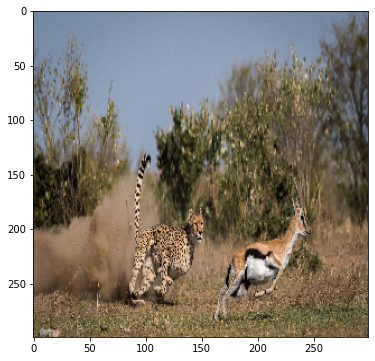

In [ ]:
# Side length of image...
IMG_SIDE_LEN = 299
# Load Inception Model
inceptionModel = inception.InceptionV3()
# Load image in 299 x 299
img = image.load_img('cheetah-gazelle.jpg', target_size=(IMG_SIDE_LEN, IMG_SIDE_LEN))
# Convert to array, and expand dimensions...
# ...and finally preprocess...
imgBatch = np.expand_dims(image.img_to_array(img), axis=0)
inceptionInput = inception.preprocess_input(imgBatch)

# Show image....divide by 2 and add 0.5 because
# Inception represents images differently...
plt.figure(figsize=(6,6))
plt.imshow(inceptionInput[0] / 2 + 0.5, aspect='auto')

In [ ]:
# Send it to Inception to get a prediction!
predictions = inceptionModel.predict(inceptionInput)
# Get top 3 prediction labels and scores...
classLabels = inception.decode_predictions(predictions)[0][:3]
for _, label, score in classLabels:
  print('{} ==> {:06.4f}%'.format(label, score))

cheetah ==> 0.6721%
gazelle ==> 0.0696%
jaguar ==> 0.0104%


So it seems that, expectedly, both `cheetah` and `gazelle` are valid predictions. I expected the gazelle prediction to be a bit higher however, as I feel it is contrasting more with background in the image. The `jaguar` class comes in a far away third, but still relevant, as cheetahs and jaguars look quite similar.
### Applying LIME

In [ ]:
explainer = lime_image.LimeImageExplainer()
# Train the LIME model for our image...might take a while...
explanation = explainer.explain_instance(inceptionInput[0], inceptionModel.predict, top_labels=3, 
                                      hide_color=0, num_samples=1000,
                                      random_seed=1729)

### Showing Regions of Explanability

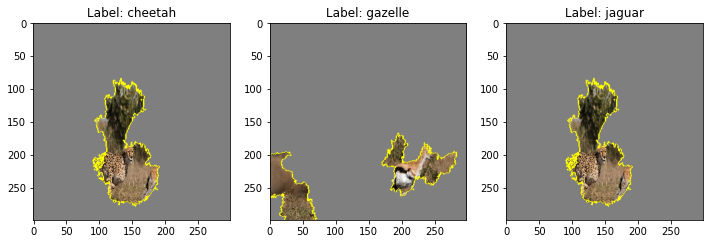

In [ ]:
# Create 3 subplots...
fig, ax = plt.subplots(1, 3, figsize=(12,12))
for i in range(3):
  # Get temp image and its mask...
  classImage, mask = explanation.get_image_and_mask(explanation.top_labels[i],
                                                    positive_only=True,
                                                    num_features=5,
                                                    hide_rest=True)
  ax[i].imshow(mark_boundaries(classImage / 2 + 0.5, mask))
  ax[i].title.set_text('Label: {}'.format(classLabels[i][1]))
# plt.figure(figsize=(15,15))
plt.show()

Interestingly, the boundaries for cheetah and jaguar appear to be the same. Additionally, the model picked up on the dust the cheetah was kicking up as evidence for a gazelle (as well as the gazelle itself).

**Optional**

If you like to learn about another promising approach to explaining NNs, you can read the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365).

# Section 3: Use Keras Tuner to optimize a small model


## Written answers

## 3a) When and why might Grid Search be less effective than Random Search when searching for useful hyperparameters for a Deep Learning model?


If you're strapped for time and resources, then Random Search is vastly better, as it can pinpoint a close-to-optimal solution much faster.

Additionally, say you're distribution of scores for the parameters has a slight peak at a value. With Grid Search, you always specify which values to test. There's a good chance that the peak would be in between those values, in which you will not even get the optimal solution. However, since Random Search is searching randomly, there's a chance that it will select something close to the peak.

## Programming questions

**3b) Add one or more code cells below in which you complete the following:**
- Install Keras Tuner
- Write a CNN to classify images from CIFAR-10 
- Use Keras Tuner to search for at least three optimal hyperpameters for your model (eg, number of layers, number of filters per layer, dropout rate, etc)

Save your output in this notebook.


In [ ]:
# We can use the CNN from Section 1...
# ....with one Conv layer removed...
# ...and test whether the ReLU or Swish is better....
def buildModel(hp):
  kernelSize = hp.Int('kernel', min_value=2, max_value=5, step=1)
  activeFnName = hp.Choice('activation', ['relu', 'swish'])
  if activeFnName == 'relu':
    activeFn = tf.nn.relu
  else:
    activeFn = swish
  model = models.Sequential([
    Conv2D(filters=hp.Int('filters1', min_value=5, max_value=40, step=5),
           kernel_size=kernelSize),
    Activation(activeFn),
    MaxPooling2D((2, 2)),
    Conv2D(filters=hp.Int('filters2', min_value=20, max_value=80, step=10),
           kernel_size=kernelSize),
    Activation(activeFn),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(hp.Int('units', min_value=10, max_value=100, step=10)),
    Dense(10)
  ])
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
tuner = RandomSearch(buildModel, 
                     objective='val_accuracy', 
                     max_trials=30, 
                     executions_per_trial=3,
                     directory='tunerResults',
                     project_name='COMS4995-3.3')

In [ ]:
tuner.search(train_images, train_labels, 
             epochs=10, 
             validation_data=(test_images, test_labels),
             verbose=0)

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_hyperparameters()

## 3c) In the text cell below, brielfy answer the following questions:
- What were the optimal hyperparmeters you found?
- Do they make sense (e.g., are they similar to parameters you might have picked yourself?)


From the output, it appears as though the optimal parameters are:


*   ReLU activation
*   25 filters for the first Conv2D layer
*   80 filters for the second Conv2D layer
*   A kernel size of 3 x 3 for both
*   30 Dense units before the final Dense layer.

They do indeed make sense, although the 30 units on the Dense layer would have seemed a bit low to me. Given that I only trained for 10 epochs each time I suspect that extremely similar values would garner similar results.



---

## Starter code for TensorBoard
The following code shows how to use [TensorBoard](https://www.tensorflow.org/tensorboard) to display the results from an experiment comparing two learning curves. Please note, there are three ways to use TensorBoard. 
- You may install TensorBoard locally on your laptop
- You can run TensorBoard inside Colab (currently buggy)
- You can use TensorBoard.dev (this is the approach you should use for this assignment). 

In [ ]:
%tensorflow_version 2.x

In [ ]:
!pip install -U tensorboard

In [ ]:
import tensorflow as tf

**Caution**. The following cell will delete any existing TensorBoard logs. If you're running this on your local machine, please be careful executing it.

In [ ]:
!rm -rf ./tensorboard-logs/ # Clear any logs from previous runs

Import a dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

## First style
The following code shows how to use TensorBoard with ```model.fit```.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten

def create_model():
  model = tf.keras.models.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='softmax'),
  ])
  return model

Create a logs directory

In [ ]:
import datetime 
import os
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

### Run an experiment
The name of the experiment is given by the path of the logs directory (here, "exp1"). You'll want to use something more descriptive in your work (e.g., "swish-cifar-10").

In [ ]:
from tensorflow.keras.optimizers import SGD

model = create_model() 
opt = SGD(learning_rate=0.001, momentum=0.0, nesterov=False) 
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

exp_dir = os.path.join(log_dir, "exp1")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tb_callback])

### Run a second experiment
Let's train another model, this time saving results to "exp2". Later, we'll be able to compare the learning curves of these experiments in TensorBoard.

In [ ]:
model = create_model() 
opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

exp_dir = os.path.join(log_dir, "exp2")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=exp_dir)

model.fit(x_train,
          y_train,
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tb_callback])

### Upload the logs to TensorBoard.dev, and compare the results
TensorBoard.dev is a hosted version of TensorBoard (see http://tensorboard.dev/ for details).

In [ ]:
!tensorboard dev upload --logdir "$log_dir"

## Second style
Showing how to use TensorBoard with a Subclassed model and a GradientTape

Prepre the dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = train_ds.shuffle(60000).batch(32)
test_ds = test_ds.batch(32)

Define a simple model

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.flatten = Flatten(input_shape=(28, 28))
    self.d1 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

model = MyModel()

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

Training and testing routines

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_fn(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

Prepare log writers (previously, these were handled by the callback)

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./tensorboard-logs/", date)
print("Writing logs to", log_dir)

train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(log_dir, "test"))

Train and log summaries

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  
  for images, labels in train_ds:
    train_step(images, labels)
    
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  
  with train_writer.as_default():
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', train_loss.result(), step=epoch)

    # ====
    # Demo: show how to use histogram summaries
    # Create and log some random data
    # Useful if you're attemping the extra credit question
    # ====
    data = tf.random.normal((32, 100))
    tf.summary.histogram('random', 
                         data,
                         step=epoch, 
                         description='Your description')
    
  with test_writer.as_default():
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    
  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

### Upload the logs to TensorBoard.dev

In [ ]:
!tensorboard dev upload --logdir "$log_dir"